   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                  25   
1               0       0    0  ...                   1   
2               0       0    0  ...                  26   
3               0       0    0  ...                 255   
4               0       0    0  ...                 255   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.17                    0.03   
1                    0.00                    0.60   
2                    0.10                    0.05   


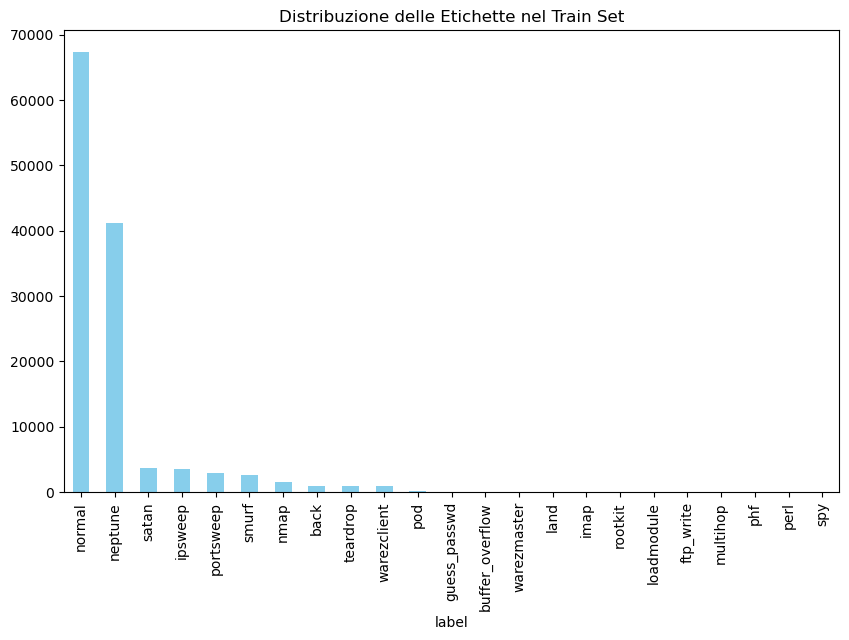

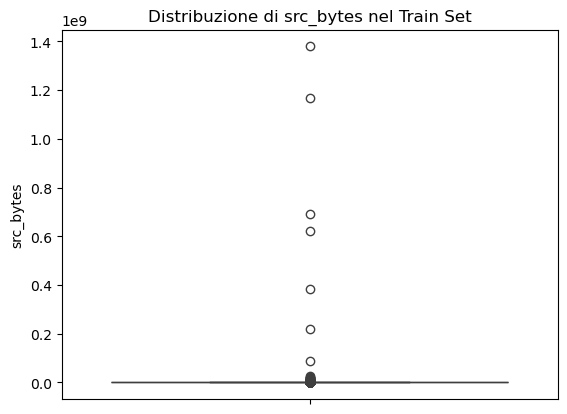

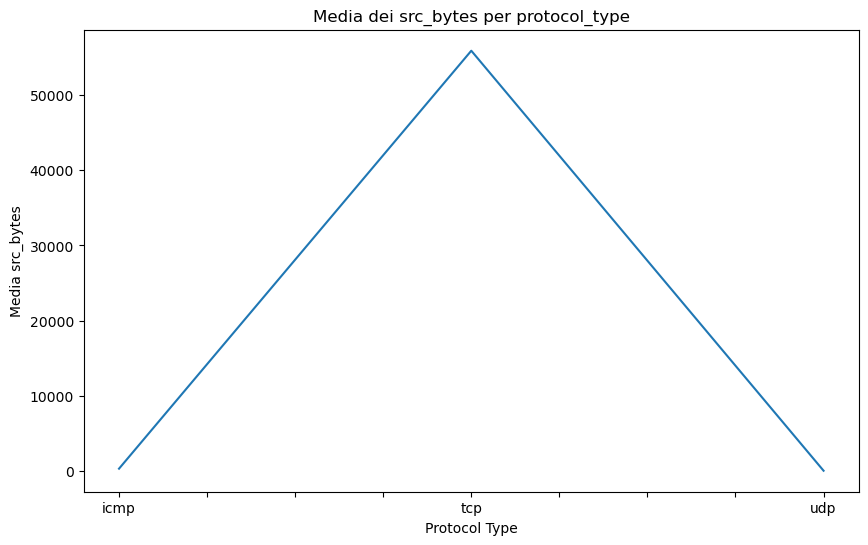

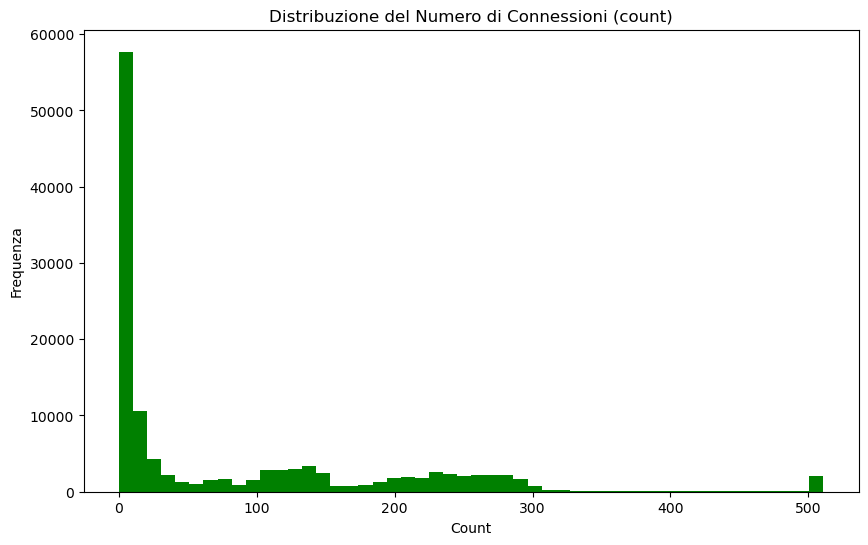

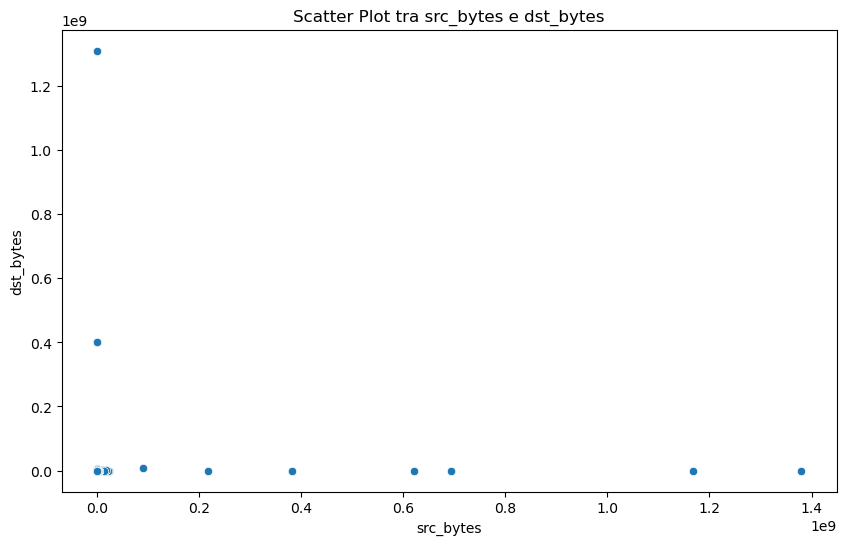

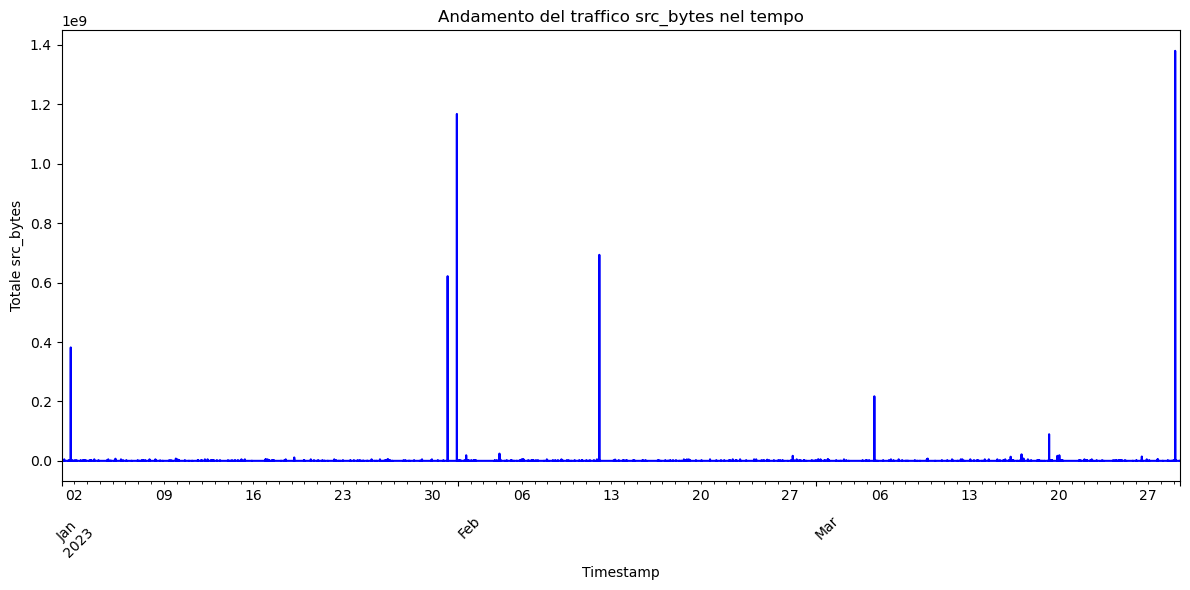

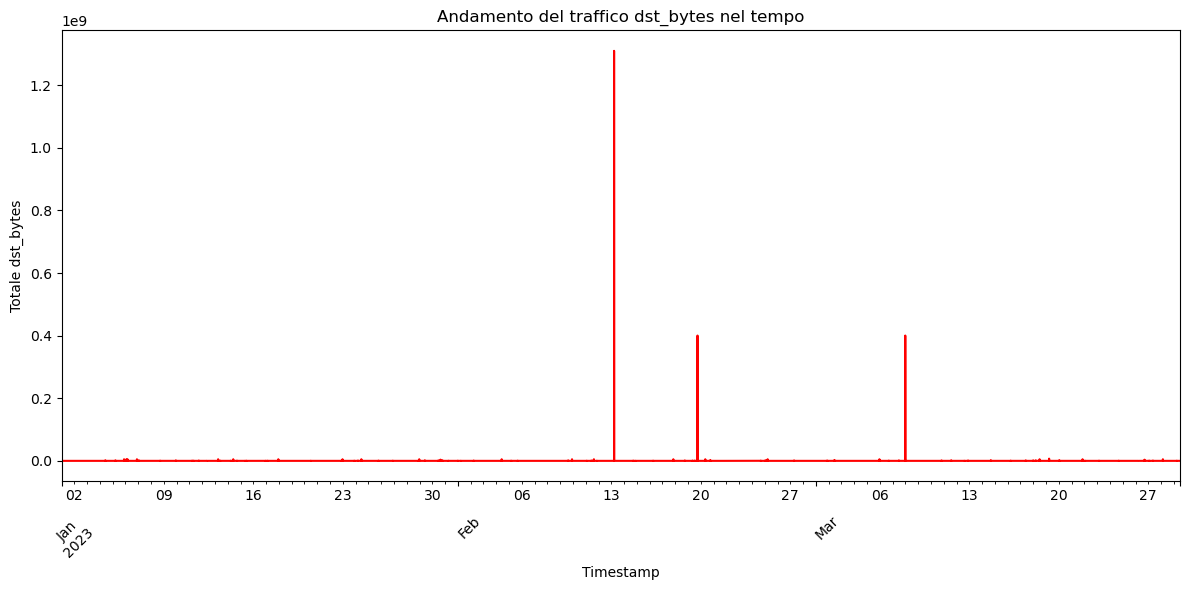

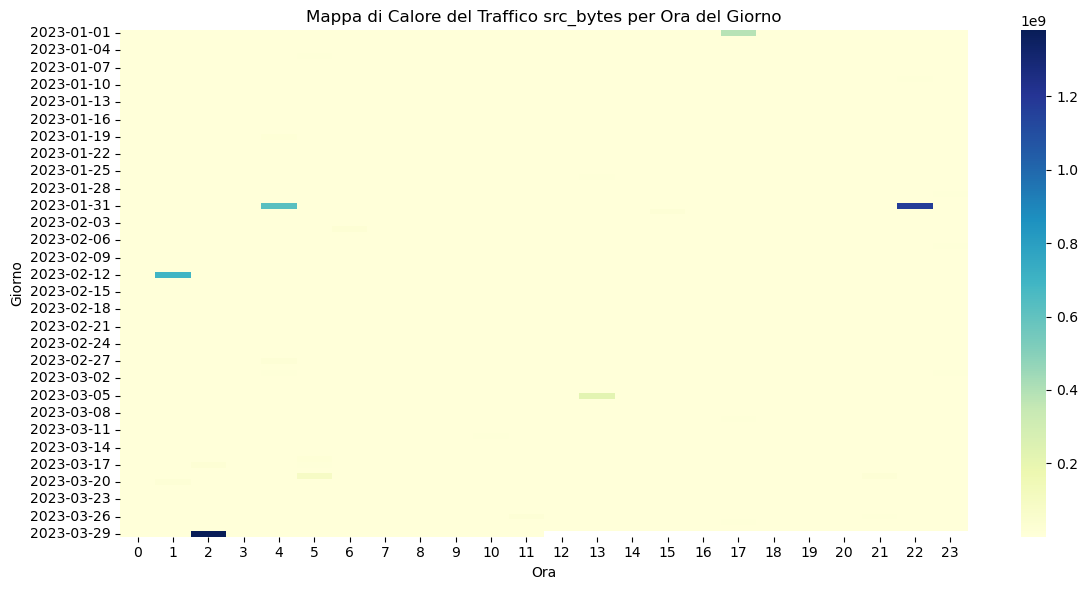

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

# 1. Caricamento dei Dati
# URL dei dataset direttamente da GitHub
train_url = 'https://raw.githubusercontent.com/Mamcose/NSL-KDD-Network-Intrusion-Detection/refs/heads/master/NSL_KDD_Train.csv'
test_url = 'https://raw.githubusercontent.com/Mamcose/NSL-KDD-Network-Intrusion-Detection/refs/heads/master/NSL_KDD_Test.csv'

# Definiamo i nomi delle colonne
col_names = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent", "hot",
             "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
             "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login", "count", "srv_count",
             "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate",
             "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
             "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]

# Caricamento dei dataset direttamente dalle URL
df_train = pd.read_csv(train_url, header=None, names=col_names)
df_test = pd.read_csv(test_url, header=None, names=col_names)

# 2. Pulizia dei Dati
df_train.drop_duplicates(inplace=True)
df_train.dropna(inplace=True)
df_test.drop_duplicates(inplace=True)
df_test.dropna(inplace=True)

# Esplorazione iniziale dei dati
print(df_train.head())
print(df_train['label'].value_counts())  # Distribuzione delle etichette

# 3. Calcolo del punteggio di rischio
def calcola_punteggio_rischio(row):
    rischio = 0
    if row['src_bytes'] > 5000:
        rischio += 3
    if row['num_failed_logins'] > 3:
        rischio += 2
    if row['protocol_type'] in ['icmp', 'udp']:
        rischio += 1
    return rischio

df_train['rischio'] = df_train.apply(calcola_punteggio_rischio, axis=1)

# Visualizziamo le righe con rischio elevato
rischio_alto = df_train[df_train['rischio'] >= 4]
print(rischio_alto)

# Calcolo della media e deviazione standard per 'src_bytes' e 'dst_bytes'
media_src = df_train['src_bytes'].mean()
dev_std_src = df_train['src_bytes'].std()

media_dst = df_train['dst_bytes'].mean()
dev_std_dst = df_train['dst_bytes'].std()

# Identificazione delle anomalie basate sulla deviazione standard
anomalie_src = df_train[df_train['src_bytes'] > media_src + 2 * dev_std_src]
anomalie_dst = df_train[df_train['dst_bytes'] > media_dst + 2 * dev_std_dst]

print(f"Anomalie src_bytes rilevate basate su deviazione standard: {anomalie_src.shape[0]}")
print(f"Anomalie dst_bytes rilevate basate su deviazione standard: {anomalie_dst.shape[0]}")

# 4. Simulazione del timestamp fittizio
# Aggiungiamo una colonna timestamp con intervalli di 1 minuto tra ogni record, partendo dal 1° gennaio 2023
start_time = pd.Timestamp('2023-01-01 00:00:00')
df_train['timestamp'] = [start_time + timedelta(minutes=i) for i in range(len(df_train))]

# Visualizziamo le prime righe per confermare l'aggiunta del timestamp
print(df_train[['timestamp', 'src_bytes', 'dst_bytes']].head())

# 5. Visualizzazioni Avanzate
plt.figure(figsize=(10,6))
df_train['label'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribuzione delle Etichette nel Train Set')
plt.show()

sns.boxplot(df_train['src_bytes'])
plt.title('Distribuzione di src_bytes nel Train Set')
plt.show()

df_train.groupby('protocol_type')['src_bytes'].mean().plot(kind='line', figsize=(10,6))
plt.title('Media dei src_bytes per protocol_type')
plt.xlabel('Protocol Type')
plt.ylabel('Media src_bytes')
plt.show()

# Istogramma della distribuzione di 'count' (numero di connessioni)
plt.figure(figsize=(10,6))
df_train['count'].plot(kind='hist', bins=50, color='green')
plt.title('Distribuzione del Numero di Connessioni (count)')
plt.xlabel('Count')
plt.ylabel('Frequenza')
plt.show()

# Scatter plot per visualizzare la relazione tra src_bytes e dst_bytes
plt.figure(figsize=(10,6))
sns.scatterplot(x='src_bytes', y='dst_bytes', data=df_train)
plt.title('Scatter Plot tra src_bytes e dst_bytes')
plt.show()

# 6. Grafico a Linee basato sul Timestamp (src_bytes)
plt.figure(figsize=(12,6))
df_train.groupby('timestamp')['src_bytes'].sum().plot(kind='line', color='blue')
plt.title('Andamento del traffico src_bytes nel tempo')
plt.xlabel('Timestamp')
plt.ylabel('Totale src_bytes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Grafico a Linee per dst_bytes nel tempo
plt.figure(figsize=(12,6))
df_train.groupby('timestamp')['dst_bytes'].sum().plot(kind='line', color='red')
plt.title('Andamento del traffico dst_bytes nel tempo')
plt.xlabel('Timestamp')
plt.ylabel('Totale dst_bytes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 7. Mappa di Calore nel Tempo per src_bytes
# Raggruppiamo i dati per ore per ridurre la granularità
df_train['hour'] = df_train['timestamp'].dt.hour

# Creiamo una tabella pivot per visualizzare src_bytes per ogni ora del giorno
heatmap_data = df_train.pivot_table(values='src_bytes', index=df_train['timestamp'].dt.date, columns='hour', aggfunc='sum')

# Visualizziamo la mappa di calore
plt.figure(figsize=(12,6))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=False)
plt.title('Mappa di Calore del Traffico src_bytes per Ora del Giorno')
plt.xlabel('Ora')
plt.ylabel('Giorno')
plt.tight_layout()
plt.show()

# 8. Esportazione dei Risultati con la colonna timestamp
df_train[['src_bytes', 'dst_bytes', 'rischio', 'timestamp']].to_csv('risultati_finali_con_timestamp.csv', index=False)